In [1]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
path = ('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/sensing/conversation/conversation.zip')
zip_file = ZipFile(path)

# Creating dictionary with each file in the zip file loaded into a
# Pandas DataFrame as a value. Keys are the file names
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

# Adding a column to each dataframe that identifies the student id (each
# dataframe represents one student)
for df_key in dfs:
    df = dfs[df_key]
    df['uid'] = df_key

# Concatening all dataframes from dictionary
convo = pd.concat([dfs[df] for df in dfs],
                  sort=False)

convo.uid = convo.uid.str.split('conversation_u').str.get(1).str.split('.csv').str.get(0).astype(int)

In [3]:
convo.columns = convo.columns.str.strip()

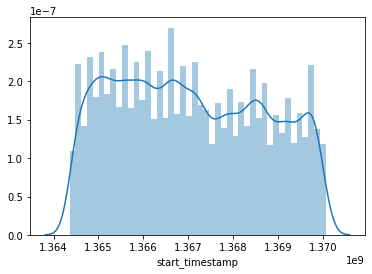

In [4]:
# Num convos over period
sns.distplot(convo.start_timestamp)

In [5]:
convo['start_datetime'] = pd.to_datetime(convo.start_timestamp, unit='s')
convo.start_datetime.dt.weekday.value_counts()

2    12223
0    11904
4    11634
1    11524
3    10847
6    10522
5    10369
Name: start_datetime, dtype: int64

In [6]:
days = (max(convo.start_datetime.dt.dayofyear) -
        min(convo.start_datetime.dt.dayofyear)
       )

66

(0.6, 0.9)

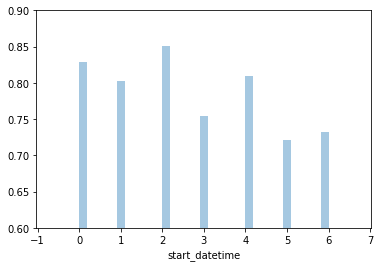

In [6]:
# Num convos over week
dplot = sns.distplot(convo.start_datetime.dt.weekday)
plt.ylim(.6,.9)

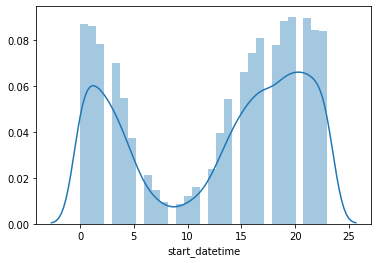

In [7]:
# Num convos over hour
dplot = sns.distplot(convo.start_datetime.dt.hour)

2634.1


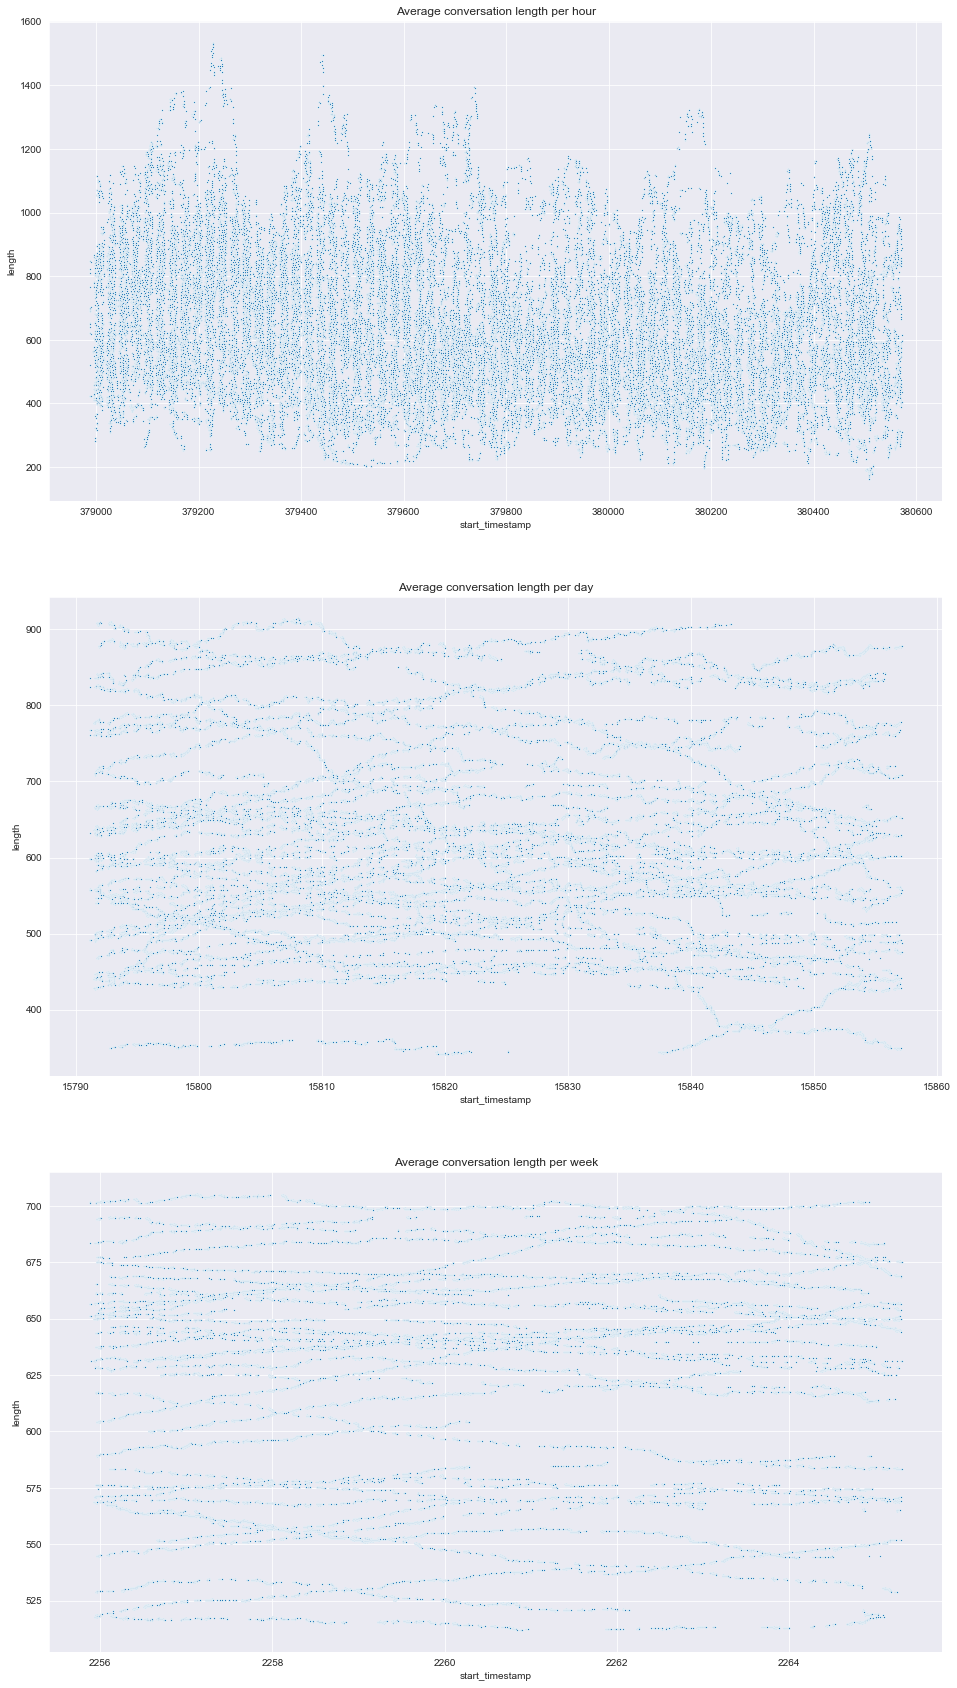

CPU times: user 3.49 s, sys: 96 ms, total: 3.59 s
Wall time: 3.72 s


In [8]:
%%time
# Average conversation length by week, by day, by hour
sns.set_style("darkgrid")

# Creating variable for conversation length
convo['length'] = convo.end_timestamp - convo.start_timestamp

# Calculating average number of conversations per day
per_day = len(convo) / (max(convo.start_datetime.dt.day) - min(convo.start_datetime.dt.day))
print(per_day)

# Plotting rolling mean by hour of the day, by weekday, and by week
plt.figure(figsize=(16,30))

plt.subplot(311)
sns.scatterplot(
    x=convo.start_timestamp/60/60,
    # Divide 'per_day' by 24 to get observations per hour
    y=convo.length.rolling(int(per_day/24)).mean(),
    s=5,
    alpha=.9)
plt.title('Average conversation length per hour')

plt.subplot(312)
sns.scatterplot(
    x=convo.start_timestamp/60/60/24,
    # Divide 'per_day' by 24 to get observations per hour
    y=convo.length.rolling(int(per_day)).mean(),
    s=5,
    alpha=.9)
plt.title('Average conversation length per day')

plt.subplot(313)
sns.scatterplot(
    x=convo.start_timestamp/60/60/24/7,
    # Divide 'per_day' by 24 to get observations per hour
    y=convo.length.rolling(int(per_day*7)).mean(),
    s=5,
    alpha=.9)
plt.title('Average conversation length per week')

plt.show()

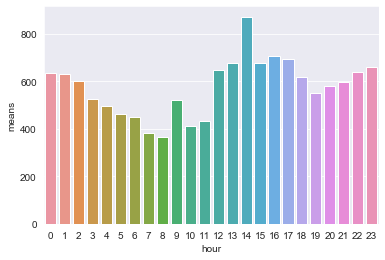

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
hour     24 non-null int64
means    24 non-null float64
dtypes: float64(1), int64(1)
memory usage: 512.0 bytes
CPU times: user 663 ms, sys: 18.1 ms, total: 682 ms
Wall time: 689 ms


In [66]:
%%time
avg_lengths_by_hr = pd.DataFrame(
    {'hour': [hour for hour in convo.start_datetime.dt.hour.unique()],
     'means': [convo.loc[convo.start_datetime.dt.hour==hour,
                      'length'
                     ].mean()
                  for hour in convo.start_datetime.dt.hour.unique()]
    })

sns.barplot(
    y='means',
    x='hour',
    orient='v',
    data=avg_lengths_by_hr
)
plt.show()

avg_lengths_by_hr.info()

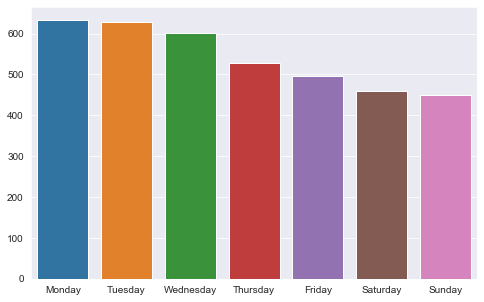

CPU times: user 387 ms, sys: 108 ms, total: 495 ms
Wall time: 589 ms


In [72]:
%%time
hr_means = [convo.loc[convo.start_datetime.dt.hour==weekday,
                      'length'
                     ].mean()
            for weekday in convo.start_datetime.dt.weekday.unique()]
hrs = [weekday for weekday in convo.start_datetime.dt.weekday.unique()]

plt.figure(figsize=(8,5))
bplot = sns.barplot(
    y=hr_means,
    x=hrs,
    orient='v')
bplot.set_xticks(list(range(7)))
bplot.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                       'Saturday', 'Sunday'])
plt.show()

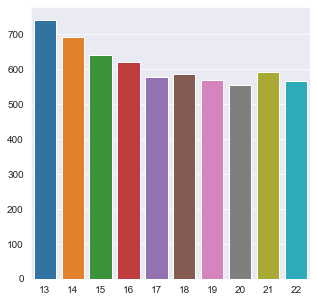

CPU times: user 429 ms, sys: 51.3 ms, total: 481 ms
Wall time: 496 ms


In [71]:
%%time
hr_means = [convo.loc[convo.start_datetime.dt.week==week,
                      'length'
                     ].mean()
            for week in convo.start_datetime.dt.week.unique()]
hrs = [week for week in convo.start_datetime.dt.week.unique()]

plt.figure(figsize=(5,5))
bplot = sns.barplot(
    y=hr_means,
    x=hrs,
    orient='v')
plt.show()

In [111]:
conversation_df = pd.DataFrame(columns=['uid', 'avg_length', 'num', 'total_min',
                                        'diff_avg_length', 'diff_num', 'diff_total_min'])
conversation_df.uid = pd.Series(convo.uid.unique())

In [112]:
avg_num_convos = len(convo) / len(conversation_df.uid)

avg_total_minutes = convo.length.sum() / len(conversation_df.uid) / 60

In [113]:
conversation_df.avg_length = [convo.loc[convo.uid==uid, 'length'].mean() for uid in conversation_df.uid]
conversation_df.num = [len(convo.loc[convo.uid==uid,:]) for uid in conversation_df.uid]
conversation_df.total_min = [convo.loc[convo.uid==uid, 'length'].sum() for uid in conversation_df.uid]

In [127]:
conversation_df.diff_avg_length = conversation_df.avg_length - conversation_df.avg_length.mean()
conversation_df.diff_num = conversation_df.num - conversation_df.num.mean()
conversation_df.diff_total_min = conversation_df.total_min - conversation_df.total_min.mean()

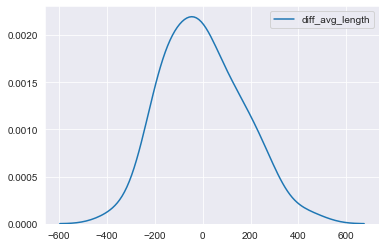

In [128]:
sns.kdeplot(conversation_df.diff_avg_length)

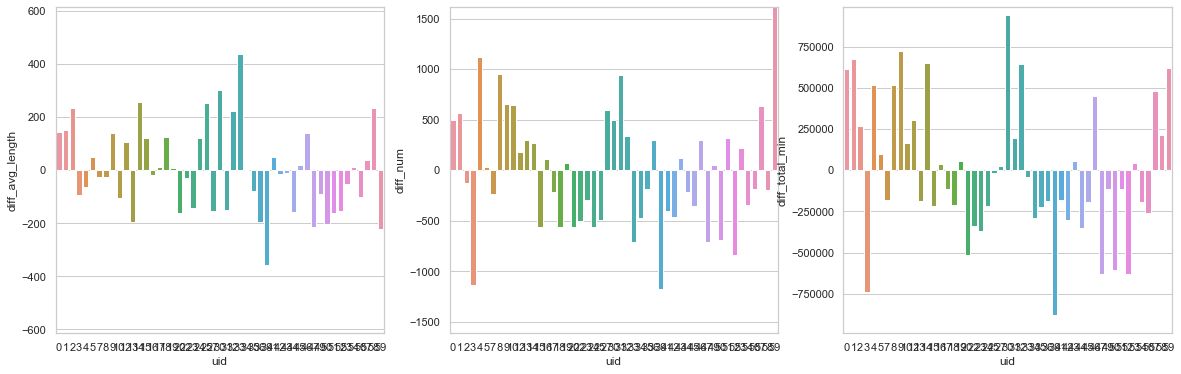

In [135]:
sns.set(style='whitegrid')

plt.figure(figsize=(20,6))

plt.subplot(131)
bplot = sns.barplot(
    x=conversation_df.uid,
    y=conversation_df.diff_avg_length
)
plt.ylim(-conversation_df.avg_length.mean(), conversation_df.avg_length.mean())

plt.subplot(132)
bplot = sns.barplot(
    x=conversation_df.uid,
    y=conversation_df.diff_num
)
plt.ylim(-conversation_df.num.mean(), conversation_df.num.mean())

plt.subplot(133)
bplot = sns.barplot(
    x=conversation_df.uid,
    y=conversation_df.diff_total_min
)
plt.ylim(-conversation_df.total_min.mean(), conversation_df.total_min.mean())
plt.show()

# K-Means

In [137]:
convo['same'] = np.nan
convo.head(5)

,start_timestamp,end_timestamp,uid,Unnamed: 0,start_datetime,length,same
0,1.364359e+09,1.364360e+09,10,NaN,2013-03-27 04:42:41,222.0,NaN
1,1.364360e+09,1.364360e+09,10,NaN,2013-03-27 04:50:14,80.0,NaN
2,1.364391e+09,1.364391e+09,10,NaN,2013-03-27 13:32:32,252.0,NaN
3,1.364392e+09,1.364392e+09,10,NaN,2013-03-27 13:48:26,192.0,NaN
4,1.364393e+09,1.364394e+09,10,NaN,2013-03-27 13:55:58,948.0,NaN


In [ ]:
%%time

for start_timestamp in convo.start_timestamp.unique():
    
    i = 0
    
    timestamp_subset = convo.loc[convo.start_timestamp==start_timestamp,:]
    
    for end_timestamp in timestamp_subset.end_timestamp.unique():
        
        convo.loc[(convo.start_timestamp==start_timestamp) &
                  (convo.end_timestamp==end_timestamp),
                  'same'
                 ] = i
        
    i = i + 1

In [148]:
conversation_df.num.mean()

1612.7142857142858

In [153]:
%%time
X = convo[['start_timestamp', 'end_timestamp']]

kmeanslabels = KMeans(n_clusters=100, random_state=42).fit_predict(X)
silhouette_score = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')

CPU times: user 2min 21s, sys: 42.6 s, total: 3min 4s
Wall time: 2min 39s


In [154]:
silhouette_score

0.6071995873619653

In [155]:
%%time
X = convo[['start_timestamp', 'end_timestamp']]

kmeanslabels_200 = KMeans(n_clusters=200, random_state=42).fit_predict(X)
silhouette_score_200 = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
silhouette_score_200

CPU times: user 2min 59s, sys: 50.2 s, total: 3min 49s
Wall time: 3min


0.6071995873619653

In [164]:
%%time
X = convo[['start_timestamp', 'end_timestamp']]

kmeanslabels_5 = KMeans(n_clusters=5, random_state=42).fit_predict(X)
silhouette_score_5 = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
silhouette_score_5

CPU times: user 1min 59s, sys: 40 s, total: 2min 39s
Wall time: 2min 45s


0.6071995873619653

In [190]:
convo['kmeans'] = kmeanslabels_5
conversation_df['kmeans0'] = np.nan
conversation_df['kmeans1'] = np.nan
conversation_df['kmeans2'] = np.nan
conversation_df['kmeans3'] = np.nan
conversation_df['kmeans4'] = np.nan

In [177]:
convo[convo.uid==0].kmeans.value_counts(ascending=False)

3    485
0    479
2    394
1    382
4    371
Name: kmeans, dtype: int64

In [218]:
vc_dict = {}
for uid in conversation_df.uid:
    vc = convo.loc[convo.uid==uid, 'kmeans'].value_counts(ascending=False).reset_index()
    vc.columns = ['cluster', 'num']
    vc.cluster = vc.cluster.astype(str)


In [219]:
for uid in conversation_df.uid:
    
    cluster_0 = vc_dict[uid].iloc[]

{10:    cluster  num
 0        4  514
 1        3  449
 2        1  445
 3        0  430
 4        2  422, 4:    cluster  num
 0        0  753
 1        3  609
 2        2  585
 3        1  557
 4        4  233, 39:    cluster  num
 0        2  216
 1        3  117
 2        1  102, 5:    cluster  num
 0        3  437
 1        1  360
 2        4  307
 3        0  291
 4        2  245, 7:    cluster  num
 0        1  563
 1        2  416
 2        0  226
 3        3  168, 13:    cluster  num
 0        2  484
 1        3  431
 2        4  377
 3        0  356
 4        1  267, 12:    cluster  num
 0        4  427
 1        0  427
 2        1  398
 3        3  293
 4        2  251, 2:    cluster  num
 0        4  335
 1        2  313
 2        3  294
 3        1  278
 4        0  263, 16:    cluster  num
 0        2  452
 1        1  447
 2        3  370
 3        0  349
 4        4  105, 17:    cluster  num
 0        3  332
 1        4  291
 2        0  279
 3        2  260
 4        1 

In [223]:
for uid in conversation_df.uid:
    for cluster in list(range(5)):
        conversation_df.loc[conversation_df.uid==uid,
                            'kmeans'+str(cluster)] = len(convo.loc[(convo.uid==uid) &
                                                                   (convo.kmeans==cluster),
                                                                  :])

In [227]:
conversation_df.to_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/convos.csv', index=False)